In [1]:
# Import libraries
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import string
import re

# create sparkcontext
conf = SparkConf().setMaster("local").setAppName("spark_app")
sc = SparkContext.getOrCreate(conf=conf)

In [19]:
f = sc.textFile("dataset/Qatar2022.txt")

In [20]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
# define stopwords
nltk.download('stopwords')
stopword = stopwords.words('english')
# import stemmer from nltk
ps = nltk.PorterStemmer()
# import lemmatizer from nltk
wn = nltk.WordNetLemmatizer()

def abb(tweet):
    tweet = re.sub(r"im|i'm|iam", "i am", tweet)
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"she's", "she is", tweet)
    tweet = re.sub(r"that's", "that is", tweet) 
    tweet = re.sub(r"there's", "there is", tweet) 
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"where's", "where is", tweet) 
    tweet = re.sub(r"\'ll", " will", tweet)  
    tweet = re.sub(r"\'ve", " have", tweet)  
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"did't", "did not", tweet)
    tweet = re.sub(r"can't", "can not", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"have't", "have not", tweet)
    return tweet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khechab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#wc = f.map(lambda x: [x['tweet_text'] for i in x]) 
wc = f.map(lambda x: re.sub("RT", "", x))
wc = wc.map(lambda x: x.lower()) # make text smaller
wc = wc.map(lambda x: re.sub(r"@[A-Za-z0-9]+", "", x)) # remove users
wc = wc.map(lambda x: re.sub(r"\\x[A-Za-z][0-9]+", "", x)) # remove
wc = wc.map(lambda x: re.sub(r"\\u[0-9][A-Za-z]|\\U[0-9][A-Za-z]+", "", x)) # remove
wc = wc.map(lambda x: re.sub(r"&lt;/?[a-z]+&gt;", "", x)) # remove
wc = wc.map(lambda x: re.sub(r'&amp;amp;', '&', x)) # remove 
wc = wc.map(lambda x: re.sub(r"b[\s]+", "", x)) # remove b" or b'
wc = wc.map(lambda x: re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", x)) # remove urls
wc = wc.map(lambda x: re.sub(r"\\[A-Za-z0-9]+", "", x)) # remove \n
wc = wc.map(lambda x: abb(x)) # replace abb
wc = wc.map(lambda x: re.sub("[^a-zA-Z0-9\s]+", "",x)) # remove non english tweets
wc = wc.map(lambda x: re.sub('[0-9]+', '', x)) # remove numbers  
wc = wc.map(lambda x: emoji_pattern.sub(r'', x) ) # remove emojis
# remove punctuation (also @ and #) => to see them ( run string.punctuation )
wc = wc.map(lambda x: "".join([char for char in x if char not in string.punctuation])) # remove ponctuation 
# do tokenization
wc = wc.map(lambda x: re.split('\W+', x)) 
# remove_stopwords
wc = wc.map(lambda x: [word for word in x if word not in stopword]) 
# do stemming
#wc = wc.map(lambda x: [ps.stem(word) for word in x]) 
# do lemmatization
#wc = wc.map(lambda x: [wn.lemmatize(word) for word in x]) 
# merge words
wc = wc.map(lambda x: " ".join(x)) 

In [22]:
for row in wc.take(5): print(row) #f.count()

tweettext
woman faces lashes seven years prison victi rape qatar told could possibly avoid cri aminal charges married attackerfifa worldcup qatar qatar 
worldcup 
going expose leak adidas new worldcup qatar ball alrihla ugly non representative design qatars culture gonna quick giveaway guys like tweet marked luckgiveaway adidasfootball fifaworldcup 
qatar whose authorities threatened fifa worldcup organizer paolakat lashes sexual assault emirate member socalled unhumanrightscouncil unhrc also chosen biden admin represent us interests afghanistan 


In [23]:
spark = SparkSession(sc)
wc_df =wc.map(lambda x: (x))

In [24]:
from pyspark.sql import Row
row = Row("tweet_text") # Or some other column name
df=wc_df.map(row).toDF(["tweet_text"])

In [8]:
df

DataFrame[tweet_text: string]

In [25]:
pandasDF = df.toPandas()
print(pandasDF)

                                               tweet_text
0                                               tweettext
1       woman faces lashes seven years prison victi ra...
2                                               worldcup 
3       going expose leak adidas new worldcup qatar ba...
4       qatar whose authorities threatened fifa worldc...
...                                                   ...
254240  bdelatorreluca helped heraclesalmelo earn toug...
254241  bthe world cup starts days hours minutes world...
254242                bmadjaaack sportbible forget fa amp
254243  bhave say scot seen national team world cup fi...
254244  bpoppingcreasesa huge thank updates indvsl pak...

[254245 rows x 1 columns]


In [11]:
pandasDF.to_csv('dataset/new.csv',index=False)

In [26]:
pandasDF

,tweet_text
0,tweettext
1,woman faces lashes seven years prison victi ra...
2,worldcup
3,going expose leak adidas new worldcup qatar ba...
4,qatar whose authorities threatened fifa worldc...
...,...
254240,bdelatorreluca helped heraclesalmelo earn toug...
254241,bthe world cup starts days hours minutes world...
254242,bmadjaaack sportbible forget fa amp
254243,bhave say scot seen national team world cup fi...


In [27]:
# Import libraries
import pandas as pd
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    try:
        if score < 0:
            return "Negative" #2
        elif score == 0:
            return "Neutral"
        else:
            return "Positive"
    except ValueError as err:
        pass

pandasDF['subjectivity'] = pandasDF['tweet_text'].apply(getSubjectivity)
pandasDF['polarity'] = pandasDF['tweet_text'].apply(getPolarity)
pandasDF['sentiment'] = pandasDF['polarity'].apply(getAnalysis)

In [28]:
pandasDF

,tweet_text,subjectivity,polarity,sentiment
0,tweettext,0.000000,0.000000,Neutral
1,woman faces lashes seven years prison victi ra...,0.625000,0.125000,Positive
2,worldcup,0.000000,0.000000,Neutral
3,going expose leak adidas new worldcup qatar ba...,0.638636,-0.032576,Negative
4,qatar whose authorities threatened fifa worldc...,0.833333,0.500000,Positive
...,...,...,...,...
254240,bdelatorreluca helped heraclesalmelo earn toug...,0.477778,-0.029630,Negative
254241,bthe world cup starts days hours minutes world...,0.000000,0.000000,Neutral
254242,bmadjaaack sportbible forget fa amp,0.000000,0.000000,Neutral
254243,bhave say scot seen national team world cup fi...,0.600000,0.500000,Positive


In [ ]:
from wordcloud import WordCloud
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = "white", max_words = 1000,  max_font_size = 50) #bgcolor
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

wc(pandasDF["tweet_text"],'black','Common Words' ) #Frequent Words

In [ ]:
#list_of_values = ["Positive"]
#wordcloud for positive tweets
df2 = pandasDF[pandasDF['sentiment'].isin(["Positive"])]
wc(df2['tweet_text'],'black','Common Words')
#wordcloud for neutral tweets
df3 = pandasDF[pandasDF['sentiment'].isin(["Neutral"])]
wc(df3['tweet_text'],'black','Common Words')
#wordcloud for negative tweets
df4 = pandasDF[pandasDF['sentiment'].isin(["Negative"])]
wc(df4['tweet_text'],'black','Common Words')
#print(df2)
#print(pandasDF.sentiment)

In [29]:
pandasDF['sentiment'].unique()
#pandasDF['sentiment'].nunique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [30]:
#pandasDF['sentiment'].plot()
#pandasDF.plot.pie(y='sentiment')
p=pandasDF['sentiment'].value_counts()

In [31]:
p

Neutral     157203
Positive     71634
Negative     25408
Name: sentiment, dtype: int64

In [32]:
p.to_csv('dataset/dounia.csv')

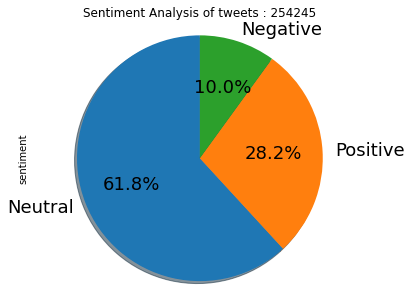

In [33]:
import matplotlib.pyplot as plt
#p.plot.pie(figsize=(6,5),fontsize=18)
my_labels=['Neutral','Positive','Negative']
p.plot.pie(figsize=(6,5),fontsize=18,labels=my_labels,autopct='%1.1f%%', shadow=True, startangle=90)
#plt.pie(p,labels=my_labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Sentiment Analysis of tweets : '+ str(pandasDF.shape[0]))
plt.axis('equal')
plt.show()

<AxesSubplot:>

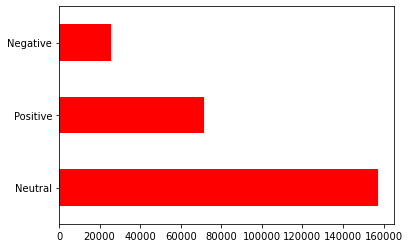

In [37]:
p.plot(kind='barh',color="r")